# Generating adversarial examples

In [1]:
! pip install -U torch torchvision --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: Generating adversarial examples on MNIST data [45 mins]

In this exercise, we will work with a computer vision model and generate adversarial examples. The generation procedure is very similar to the counterfactual generation code that developed last week.

First, follow the process below to load the model and generate some predictions.

(Adapted from [PyTorch](https://docs.pytorch.org/tutorials/beginner/fgsm_tutorial.html))

First, download a pretrained neural network model from [here](https://drive.google.com/file/d/1HJV2nUHJqclXQ8flKvcWmjZ-OU5DGatl/view?usp=drive_link). Simply open the link and press `ctrl+S`.

Next, let us put together the structure of the model.

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
# If you have a cuda GPU, feel free to set the device to "cuda"
device = "cpu"
print(f"Using {device} device")

# Initialize the network
model = Net().to(device)

model_path = "./model/lenet_mnist_model.pth"  # This is the file we downloaded
# Load the pretrained model
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Using cpu device


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Now let us download the data

In [6]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)), # Normalize the images to 0 and 1
            ])),
        batch_size=1, shuffle=True)

100%|██████████| 9.91M/9.91M [00:16<00:00, 604kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 330kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 347kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]


Some helper functions to convert the images back to the original scale

In [7]:
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

Let us compute the model accuracy

In [8]:
import tqdm 
labels = []
preds = []
for inp in tqdm.tqdm(test_loader):
    x, y = inp
    y_hat = model(x).argmax(-1).item()
    labels.append(y.item())
    preds.append(y_hat)

100%|██████████| 10000/10000 [00:11<00:00, 855.59it/s]


In [9]:
labels = np.array(labels)
preds = np.array(preds)
print(f"Accuracy: {(labels==preds).mean()}")

Accuracy: 0.9912


In [37]:
def predict(x):
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x).argmax(-1).item()
    return y_hat

Now let us plot the last image

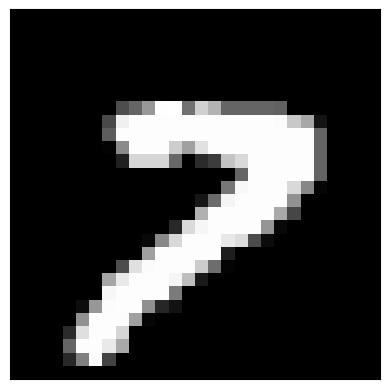

In [10]:
plt.figure()
plt.imshow(denorm(x).squeeze(0,1), cmap="gray")
plt.xticks([], [])
plt.yticks([], [])
plt.show()


## Your task

Write a function that given an input example and a target label, generates an adversarial example using the FGSM method.

Plot the original and the adversarial method.

In [160]:
# Your code here
def adversarial_example(input_example, epsilon, target_label):
    """
    Generate an adversarial example using the Fast Gradient Sign Method (FGSM).

    Args:
        input_example (torch.Tensor): The input image tensor.
        target_label (int): The target label for the adversarial example.
        epsilon (float): The perturbation magnitude.

    Returns:
        torch.Tensor: The adversarial example.
    """

    x_c = input_example.clone()
    x_c.requires_grad = True    
       
    
    pred = model(x_c)
    target = torch.tensor([target_label]).to(device)        
    model.zero_grad()
    loss_fn = F.nll_loss(pred, target)
    loss_fn.backward()
    grad_sign = x_c.grad.data.sign()
    x_c = x_c + epsilon * grad_sign * x_c.grad
    print(grad_sign)
    return x_c.detach()
    

In [156]:
x, y = next(iter(test_loader))

tensor([[[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
           -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.],
          [ 1.,  1.,  

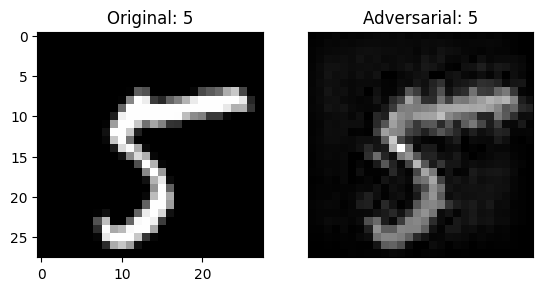

In [161]:
adv_output = adversarial_example(x, epsilon=3, target_label=1)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(denorm(x).squeeze(0,1).detach().cpu(), cmap="gray")
plt.title(f"Original: {y.item()}")
plt.subplot(1, 2, 2)
plt.imshow(adv_output.squeeze(0,1).detach().cpu(), cmap="gray")
plt.title(f"Adversarial: {predict(adv_output)}")
plt.xticks([], [])
plt.yticks([], [])
plt.show()






# Exercise 2: Counterfactual examples with sparsity [25 mins]

Take the Census Income prediction task from last lecture. Generate counterfactuals with a L1 distance metric as a part of the objective function.

Try different strenghts of the L1 norm. What differences do you observe w.r.t. the original counterfactual?

You can use the solution from the last week. Its already uploaded on Moodle.

In [164]:
from folktables import ACSDataSource, ACSEmployment

def load_pums():
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["AL"], download=True)  # Limiting to AL. You can try another state or all the states.
    x, y, _ = ACSEmployment.df_to_numpy(acs_data)  # The group in this case is the race. It is also included in the features.
    return x, y, ACSEmployment.features


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
x, y, names = load_pums()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

batch_size = 16

def convert_x_y_to_tensors(x, y):
    # Takes numpy arrays and convert them to PyTorch tensors.
    # Torch expects data to be in torch.Tensor objects
    x = torch.from_numpy(x)
    x = x.to(dtype=torch.float) # Features are floats
    y = torch.from_numpy(y).long()
    return x, y

# TODO: Add code to split the data in train and test sets
x_train, y_train = convert_x_y_to_tensors(x_train, y_train)
x_test, y_test = convert_x_y_to_tensors(x_test, y_test)


# We only make the data loader for the train set
# Test and validation set (if available) are small so we can run the model in a full batch setting
# You can similarly convert them to data loaders if the datasets are too large
train_loader = DataLoader(
    TensorDataset(x_train, y_train), 
    batch_size=batch_size, 
    shuffle=True,             # Shuffle at every epoch
)

for batch in train_loader:
    x_batch, y_batch = batch  # Unpack the batch
    # print(f"Batch shape is x: {x_batch.shape} -- y: {y_batch.shape}")

Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch shape is x: torch.Size([16, 16]) -- y: torch.Size([16])
Batch sh

In [168]:
# All neural networks should inherit from nn.Module which implements some basic methods
from torch.nn import Module, Linear, ReLU, Sequential
class MyFirstNN(Module):
    def __init__(self, n_features, n_classes, hidden_units):     # Operations to carry out when we initialize the model
        super(MyFirstNN, self).__init__()                        # Call the __init__ of the super, or parent, class
        # Let us construct the layers one by one
        layers = []
        n_in = n_features
        for n_out in hidden_units:
            layers.append(Linear(n_in, n_out))  # Recall that a layer is just a mapping from an input to the output
            layers.append(ReLU())
            n_in = n_out
        layers.append(Linear(n_in, n_classes))

        # Next, tell pytorch that the layers are applied in sequence
        self.layers = Sequential(*layers)  # The * operator just unpacks all the layers
        
    def forward(self, x):
        # You should define the behavior of your NN when applied to the data.
        # In this case, we simply apply the layers one after the other.
        # The outputs are the logits, that is, the real-values scores for each class.
        return self.layers(x)
    
    def predict(self, x):
        # This function gives the prediction label.
        with torch.no_grad():
            if isinstance(x, np.ndarray):  # PyTorch models always expect tensors.
                x = torch.FloatTensor(x)
            preds = self(x)  # Apply the model
            pred_class = preds.argmax(axis=1)  # We get the logits for each class, select the one with the highest score
        return pred_class

my_first_nn = MyFirstNN(n_features=x_train.shape[1], n_classes=2, hidden_units=[1024, 1024])
print(my_first_nn)

MyFirstNN(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)


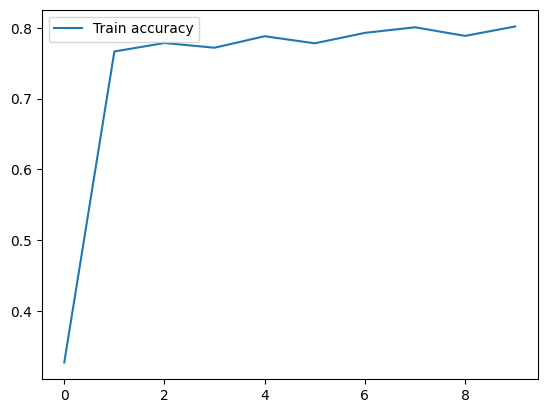

In [170]:
def compute_accuracy(model, x, y):
    preds = model.predict(x)
    return (preds==y).sum() / preds.shape[0]

print(f"Train accuracy: {compute_accuracy(my_first_nn, x_train, y_train):0.2f}")

%matplotlib inline
learning_rate = 1e-2  # Try different values
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    my_first_nn.parameters(),  # The parameters that we should optimize
    lr=learning_rate
)

from IPython import display

num_epochs = 10

def train_model(num_epochs):
    train_accs = []
    my_first_nn.train()  # Put the model in the trianing mode
    
    plt.figure()
    ax = plt.gca()
    
    for epoch in range(num_epochs):
        # -----------------------------'------------------
        # Print the performance at the end of each epoch
        # -----------------------------------------------
        my_first_nn.eval()  # Put the model in evaluation mode
        train_accs.append(compute_accuracy(my_first_nn, x_train, y_train))  # If the trainig data is large, you may want to do this iteratively with a data loader
        ax.clear()
        ax.plot(range(epoch+1), train_accs, label="Train accuracy")
        plt.legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        my_first_nn.train() # Put the model back in training model
        
        # --------------------------------------------
        # Train the model on all batches in the epoch
        # --------------------------------------------
        for batch in train_loader:
            x_batch, y_batch = batch  # Unpack the batch
    
            # Compute the loss
            pred = my_first_nn(x_batch)
            loss = loss_fn(pred, y_batch)
    
            # Take a gradient step
            loss.backward()        # Compute the gradient
            optimizer.step()       # Update the parameters
            optimizer.zero_grad()  # Zero out the gradients for the next iteration

train_model(num_epochs)

In [242]:
def calculate_l_norm(x_current, x_start):
    binary_idx = []
    binary_idx = [2, 3, 5, 6, 7, 9, 10, 14, 15]
    x_cur = x_current.clone().detach().cpu().numpy()
    x_st = x_start.clone().detach().cpu().numpy()
    sum = 0.
    for i in range(x_cur.shape[0]):
        if i in binary_idx:
            sum += 4 if x_cur[i] != x_st[i] else 0
        else:
            sum += abs(x_cur[i][0] - x_st[i][0])
    print(f"l1 norm: {sum}")  
    return sum
    

In [ ]:
x_selected = x_test[1]
y_pred = my_first_nn.predict(x_selected.reshape(1,-1))
y_target = torch.abs(1-y_pred)

x_c = x_selected.clone().reshape(1,-1)
x_start = x_c.clone()
x_c = x_c.to(device)
x_c.requires_grad_(True)

print("Model pred:", y_pred.item())
print("Counterfactual target:", y_target.item())


learning_rate = 1e-1  # Try different values
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [x_c],  # The parameters that we should optimize
    lr=learning_rate
)

max_iter = 1000
for iter_num in range(max_iter):

    # Forward pass
    pred = my_first_nn(x_c)
    if pred.flatten().argmax(-1).item() == y_target.item():
        print(f"Found counterfactual input in iteration # {iter_num}")
        break

    # Compute loss
    p_loss = loss_fn(pred, y_target) 
    norm = calculate_l_norm(x_c, x_start)
    
    loss = p_loss + 5*norm
    print(f"Iteration {iter_num} -- Loss: {loss} -- L1 norm: {norm} -- Pred: {pred.flatten().argmax(-1).item()} -- Target: {y_target.item()}")
    # add L1 norm to the loss
    
    # Take a gradient step
    loss.backward()        # Compute the gradient
    optimizer.step()       # Update the parameters
    optimizer.zero_grad()  # Zero out the gradients for the next iteration




Model pred: 1
Counterfactual target: 0
l1 norm: 0.0
Iteration 0 -- Loss: 1.1723400354385376 -- L1 norm: 0.0 -- Pred: 1 -- Target: 0
l1 norm: 0.012451171875
Iteration 1 -- Loss: 1.0758192539215088 -- L1 norm: 0.012451171875 -- Pred: 1 -- Target: 0
l1 norm: 0.02423858642578125
Iteration 2 -- Loss: 0.9923328161239624 -- L1 norm: 0.02423858642578125 -- Pred: 1 -- Target: 0
l1 norm: 0.0352020263671875
Iteration 3 -- Loss: 0.9252091646194458 -- L1 norm: 0.0352020263671875 -- Pred: 1 -- Target: 0
l1 norm: 0.04541015625
Iteration 4 -- Loss: 0.8693439364433289 -- L1 norm: 0.04541015625 -- Pred: 1 -- Target: 0
Found counterfactual input in iteration # 5


In [245]:
original = x_selected.flatten().detach().numpy()
counterfactual = x_c.flatten().detach().numpy()
for fo, fc, n in zip(original, counterfactual, names):
    print(f"{n: <10} | {fo:0.2f} | {fc:0.2f}")



AGEP       | 66.00 | 66.05
SCHL       | 23.00 | 22.90
MAR        | 3.00 | 3.03
RELP       | 0.00 | 0.07
DIS        | 2.00 | 1.65
ESP        | 0.00 | 0.00
CIT        | 1.00 | 0.95
MIG        | 1.00 | 1.00
MIL        | 4.00 | 3.89
ANC        | 2.00 | 1.97
NATIVITY   | 1.00 | 1.00
DEAR       | 2.00 | 1.97
DEYE       | 2.00 | 1.94
DREM       | 2.00 | 1.79
SEX        | 2.00 | 2.23
RAC1P      | 1.00 | 1.00


# Exercise 3: Feature-aware distance function and post-processing counterfactuals [25 mins]

Now change the distance function so that for categorical features, you do not use the L1 distance, but the $\mathbb{I}[x \neq x_c]$.

Also, post process the counterfactuals. Change as many features as possible to original values while still preserving the counterfactual label.

In [ ]:
# Your code here